In [1]:
import os
import random
import numpy as np

from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [2]:
gestures = set()

In [3]:
data_filenames = []

for subject_dir in os.listdir(f'dataset'):
    if 'pilot' not in subject_dir and 'README' not in subject_dir:
        for velo_dir in os.listdir(f'dataset/{subject_dir}'):
            for filename in os.listdir(f'dataset/{subject_dir}/{velo_dir}'):
                gestures.add(filename[:-6])
                if 'checkpoints' not in filename:
                    path = os.path.normpath(f'dataset/{subject_dir}/{velo_dir}/{filename}')
                    data_filenames.append(path)


In [4]:
random.shuffle(data_filenames)
test_filenames = []
train_filenames = []
for gesture in gestures:
    gest_filenames = [filename for filename in data_filenames if gesture in filename]
    test_filenames.extend(gest_filenames[:10])
    train_filenames.extend(gest_filenames[10:])
len(test_filenames)


160

In [5]:
data_test = []
for filename in test_filenames:
    root = ET.parse(filename).getroot()
    label = filename.split('/')[3][:-6]
    points = []
    for point in root:
        x = point.attrib['X']
        y = point.attrib['Y']
        points.append([x, y])
    points = np.array(points, dtype=float)
    scaler = StandardScaler()
    points = scaler.fit_transform(points)
    resampled = resample(points, NUM_POINTS)
    data_test.append((label, resampled))

In [6]:
data_train = []
for filename in train_filenames:
    root = ET.parse(filename).getroot()
    label = filename.split('/')[3][:-6]
    points = []
    for point in root:
        x = point.attrib['X']
        y = point.attrib['Y']
        points.append([x, y])
    points = np.array(points, dtype=float)
    scaler = StandardScaler()
    points = scaler.fit_transform(points)
    resampled = resample(points, NUM_POINTS)
    data_train.append((label, resampled))

In [7]:
labels_test = [sample[0] for sample in data_test]
labels_train = [sample[0] for sample in data_train]

print(len(set(labels_test)))
print(len(set(labels_train)))

encoder = LabelEncoder()
labels_test_encoded = encoder.fit_transform(labels_test)
labels_train_encoded = encoder.fit_transform(labels_train)
y_test = to_categorical(labels_test_encoded)
y_train = to_categorical(labels_train_encoded)

sequences_test = [sample[1] for sample in data_test]
sequences_train = [sample[1] for sample in data_train]
X_test = np.array(sequences_test)
X_train = np.array(sequences_train)

16
16


In [8]:
print(set(labels_test))
print(set(labels_train))

{'x', 'left_curly_brace', 'left_sq_bracket', 'check', 'caret', 'star', 'question_mark', 'pigtail', 'arrow', 'delete_mark', 'right_sq_bracket', 'v', 'rectangle', 'triangle', 'circle', 'right_curly_brace'}
{'x', 'left_sq_bracket', 'check', 'caret', 'question_mark', 'star', 'pigtail', 'arrow', 'triangle', 'delete_mark', 'right_sq_bracket', 'v', 'rectangle', 'left_curly_brace', 'circle', 'right_curly_brace'}


In [17]:
# Define the model
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates
model.add(LSTM(64, input_shape=(NUM_POINTS, 2)))

# add dense layer to do machine learning magic
model.add(Dense(32, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance

# softmax layer for classification
model.add(Dense(len(set(labels_test)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)


In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_test)

(10070, 50, 2) (160, 50, 2) (10070, 16) (160, 16)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
print(y_test)
print(y_test.shape)
print(y_train.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(160, 16)
(10070, 16)


In [18]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early],
)

Epoch 1/20
315/315 [==============================] - 12s 28ms/step - loss: 0.7306 - accuracy: 0.7993 - val_loss: 0.0953 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 2/20
315/315 [==============================] - 8s 26ms/step - loss: 0.0802 - accuracy: 0.9789 - val_loss: 0.0398 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 3/20
315/315 [==============================] - 8s 26ms/step - loss: 0.0473 - accuracy: 0.9877 - val_loss: 0.0192 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 4/20
315/315 [==============================] - 8s 25ms/step - loss: 0.0333 - accuracy: 0.9919 - val_loss: 0.0228 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 5/20
315/315 [==============================] - 8s 27ms/step - loss: 0.0240 - accuracy: 0.9944 - val_loss: 0.0442 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 6/20
315/315 [==============================] - 9s 27ms/step - loss: 0.0114 - accuracy: 0.9976 - val_loss: 0.0060 - val_accuracy: 1.0000 - lr: 2.0000e-04
Epoch 7/20
315/315 [==============================] - 10s 3

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17152     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
Total params: 19,760
Trainable params: 19,760
Non-trainable params: 0
_________________________________________________________________


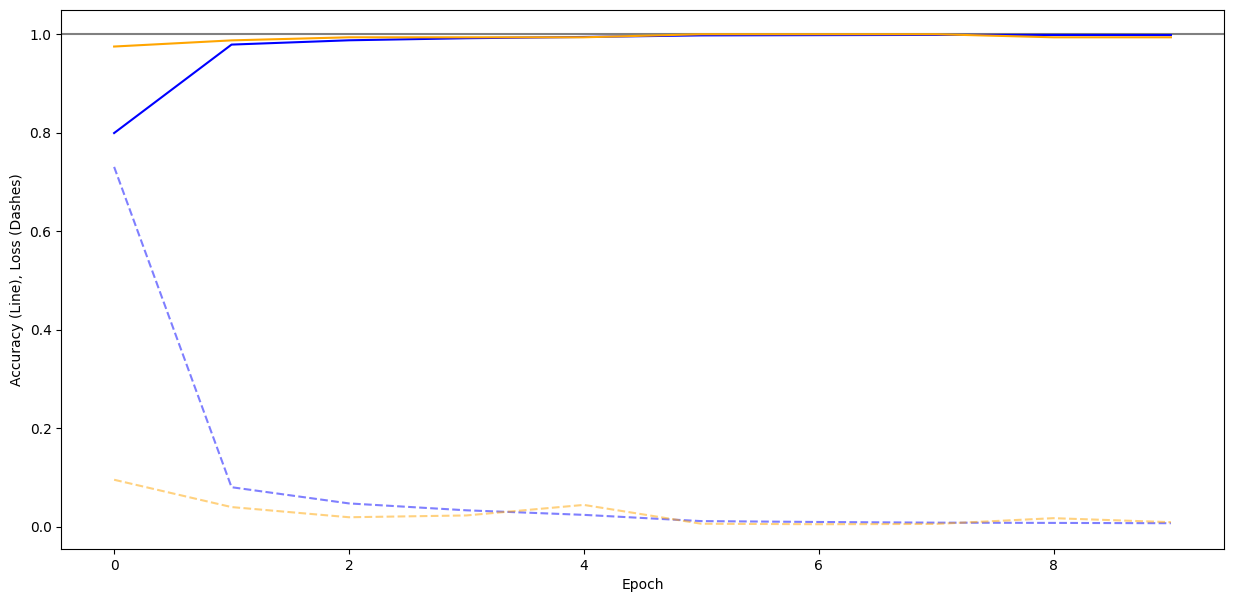

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

5/5 [==============================] - 1s 9ms/step


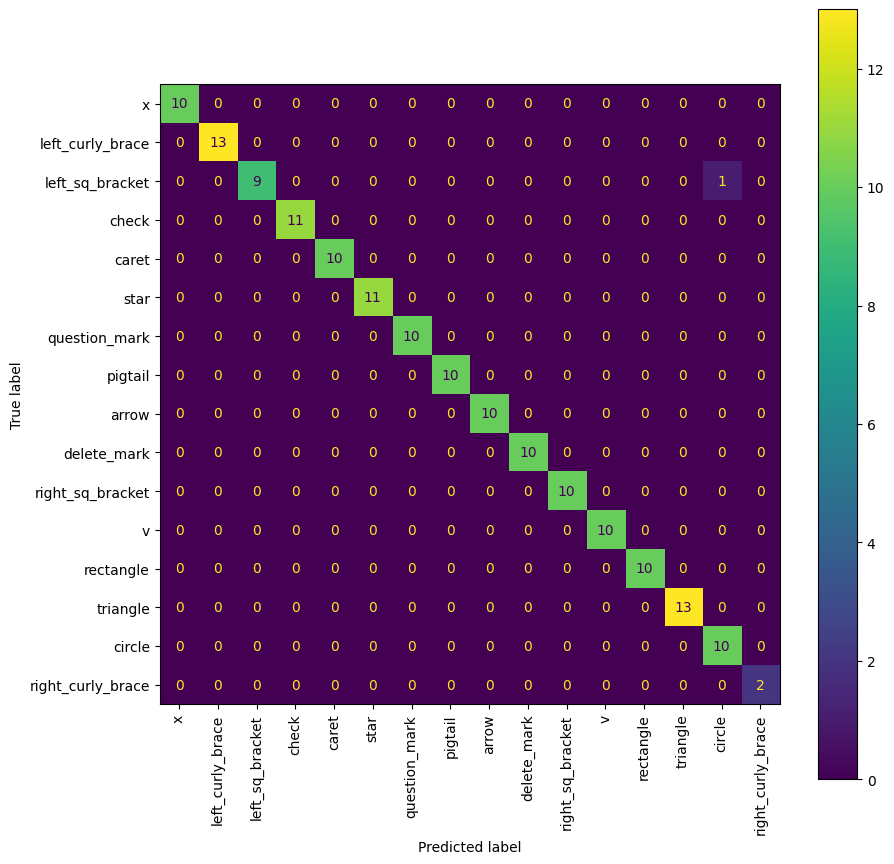

In [21]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels_test)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass